# Storm tracking with CCIC 

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

## library for tracking
import tobac

# needed to read in CCIC .zarr files
import ccic

# set CCIC plotting style
from ccic.plotting import set_style
set_style()

**Storm tracking in satellite data** 

Tracking storm objects over time is useful for many weather and climate related applications because it is possible to follow the lifecycle and derive characteristics of individual convective storms. While different atmospheric fields can be used to identify clouds and storms in satellite data, the retrieved cloud ice water path has the advantage that it is physically linked to convection and that it can be directly compared to output from weather and climate models. In addition, the CCIC dataset offers a high spatial and temporal resolution and full coverage of the globe, which enables the tracking of full storm lifecycles globally. 

This notebook shows an example of how to track convective storms using the **CCIC** dataset and the tracking library **tobac**. 


**Tracking and Object-based Analysis of Clouds (tobac)**

The python package **tobac** that is required for storm tracking can be installed with: 

*conda install -c conda-forge tobac* 

**GitHub**: https://github.com/tobac-project/tobac


## Read in global ice water path data 

In this example, we track storms based on the retrieved total ice water path (tiwp) on the original CCIC CPCIR grid (4 km grid spacing) globally during one day. We also show how to work directly with an AWS S3 bucket as well as with data locally available.

In [2]:
year = 2020
online = False
if online:
    # Create fs object to find files
    ccic_bucket = None # To be published
    fs = fsspec.filesystem("s3", anon=True)
    fnames = [
        fsspec.get_mapper('s3://{filename}')
        for filename in fs.glob(f"{ccic_bucket}/cpcir/{year}/ccic_cpcir_20200101*zarr")
    ]
else:
    data_path = Path(f'/data/ccic/record/cpcir/{year}')
    fnames = list(data_path.glob("ccic_cpcir_20200101*zarr"))

ds = xr.open_mfdataset(fnames, engine='zarr')
# field used for tracking: total ice water path 
tiwp = ds.tiwp

In [3]:
# have look at the variables stored in the CCIC dataset
ds

<xarray.Dataset>
Dimensions:        (ci_bounds: 2, time: 48, latitude: 3298, longitude: 9896)
Coordinates:
  * ci_bounds      (ci_bounds) float32 0.05 0.95
  * latitude       (latitude) float32 59.98 59.95 59.91 ... -59.91 -59.95 -59.98
  * longitude      (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 180.0
  * time           (time) datetime64[ns] 2020-01-01 ... 2020-01-01T23:30:00.0...
Data variables:
    cloud_prob_2d  (time, latitude, longitude) float32 dask.array<chunksize=(1, 413, 2474), meta=np.ndarray>
    inpainted      (time, latitude, longitude) float32 dask.array<chunksize=(1, 413, 2474), meta=np.ndarray>
    p_tiwp         (time, latitude, longitude) float32 dask.array<chunksize=(1, 413, 2474), meta=np.ndarray>
    tiwp           (time, latitude, longitude) float32 dask.array<chunksize=(1, 413, 1237), meta=np.ndarray>
    tiwp_ci        (time, latitude, longitude, ci_bounds) float32 dask.array<chunksize=(1, 413, 1237, 1), meta=np.ndarray>
Attributes:
    history:          2024-01-29 10:47:09.768914: Retrieval processing
    input_filename:   merg_2020010100_4km-pixel.nc4
    institution:      Chalmers University of Technology
    processing_time:  2024-01-29T10:47:09.768839
    references:       https://doi.org/10.5281/zenodo.8278127
    source:           framework: ccic-0.1pre
    title:            The Chalmers Cloud Ice Climatology

#### Look at one 30-min snapshot of the data 

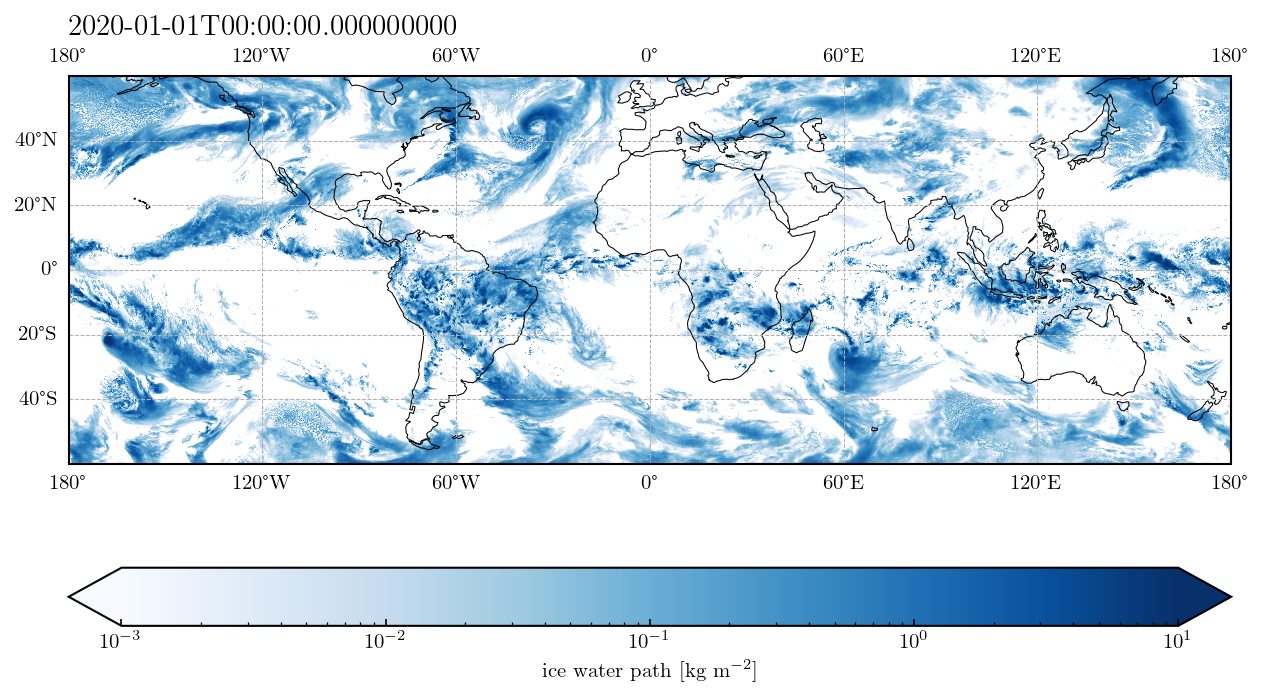

In [4]:
fig = plt.figure(figsize=(10,6))

proj = ccrs.PlateCarree()
ax = fig.add_subplot(111, projection=proj)

iwp_map = ax.pcolormesh(ds.longitude, ds.latitude, tiwp[0], cmap = 'Blues', norm = LogNorm(1e-3,1e1), transform=ccrs.PlateCarree())
ax.set_title(str(tiwp.time.values[0]), fontsize = 14)
gl= ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linestyle= '--')
ax.add_feature(cfeature.COASTLINE)
gl.right_labels = False
plt.colorbar(iwp_map, label = 'ice water path [kg m$^{-2}$]', orientation = 'horizontal', extend = 'both') 
plt.show()

### Set parameters for storm tracking 

**Detailed documentation** of how to choose and set different tracking options: https://tobac.readthedocs.io/en/latest/

In [5]:
# set horizontal grid spacing [m] and temporal resolution [s]
dxy,dt= 4000, 1800

# parameters for feature detection                                                           
parameters_features = {}
parameters_features['threshold']=[0.1, 0.5, 1 ] # thresholds for ice water path 
parameters_features['target']='maximum'
parameters_features['n_min_threshold']= 1000 # minimum number of grid cells that need to be above specified thresholds 
parameters_features['statistic'] = {"feature_min_iwp": np.nanmin, 'feature_max_iwp': np.nanmax, 'feature_mean_iwp': np.nanmean}

# parameters for linking 
parameters_linking={}
parameters_linking['v_max']=1e2
parameters_linking['stubs']=3 # minimum number of timesteps a storm has to persist 
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['method_linking']= 'predict'

# parameters for segmentation 
parameters_segmentation = {}
parameters_segmentation['threshold']= 0.01 # kg/m2 used to define the extent of the cloud objects                     
parameters_segmentation['target'] = "maximum"
parameters_segmentation['statistic'] = {"object_min_iwp": np.nanmin, 'object_max_iwp': np.nanmax, 'ob\
ject_mean_iwp': np.nanmean}

### Feature detection

As a first step, we want to detects contiguous areas associated with clouds and convection based on multiple ice water path thresholds that were set in **parameters_feature_detection**

In [6]:
# convert data to iris cube (needed input format for tobac)
iwp_iris = tiwp.to_iris()

In [7]:
# detect features based on multiple thresholds 
features = tobac.feature_detection_multithreshold(iwp_iris ,dxy, **parameters_features)

### Trajectory linking 

Next, we want to link the features between time steps to see which features belong to the same weather system. This allows us to follow the storm evolution and lifecycle. 

In [8]:
# use detected features as input for linking 
tracks = tobac.linking_trackpy(features, iwp_iris, dt, dxy, **parameters_linking)

# reduce tracks to valid cells (i.e. at prevailing > 3 hours) and those cells that contain convection (>= 1 kg/m2)                           
tracks = tracks[tracks.cell != -1]
tracks_convective = tracks.groupby("cell").feature_max_iwp.max()
valid_cells = tracks_convective.index[tracks_convective >= 1]
tracks = tracks[np.isin(tracks.cell, valid_cells)]

Frame 47: 373 trajectories present.


### Segmentation

Finally, we can also define the spatial extent of the storm objects in every time step to get a better idea how large the tracked storm systems are. The segmentation process aims at associating cloud areas with the identified and tracked features.

In [9]:
mask, tracks = tobac.segmentation_2D(tracks, iwp_iris, dxy, **parameters_segmentation)
mask = xr.DataArray.from_iris(mask) # For convenience

### Look at the tracking output

Feature detection outputs a pandas dataframe with several variables that are described in more detail here: https://tobac.readthedocs.io/en/latest/feature_detection_output.html

Note that it also contains bulk statistics of each identified storm object such as the maximum, mean, and minimum ice water path that we have defined in **parameters_segmentation** and **parameters_feature_detection**. 

In [10]:
# pandas dataframe that contains the individual tracked storm objects and their statistics in every time step 
tracks.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature_min_iwp,feature_max_iwp,feature_mean_iwp,feature,time,timestr,latitude,longitude,cell,time_cell,ncells,object_min_iwp,object_max_iwp,object_mean_iwp
0,0,5,96.898086,1987.409226,36266,0.1,0.100022,1.295776,0.220904,1,2020-01-01 00:00:00,2020-01-01 00:00:00,56.456104,-107.683173,1,0 days,119121,0.010421,1.296464,0.113736
9,0,121,205.082028,7288.685799,16604,0.1,0.100046,0.598118,0.207272,10,2020-01-01 00:00:00,2020-01-01 00:00:00,52.519755,85.168441,10,0 days,113393,0.010421,0.598125,0.071101
14,0,240,281.103842,5874.975909,4815,0.1,0.100001,1.182417,0.28903,15,2020-01-01 00:00:00,2020-01-01 00:00:00,49.753649,33.740029,15,0 days,385371,0.010421,1.486104,0.21203
16,0,242,264.894209,2206.880298,3091,0.1,0.100051,1.533851,0.438006,17,2020-01-01 00:00:00,2020-01-01 00:00:00,50.343453,-99.699179,17,0 days,5263,0.010421,1.555292,0.274927
23,0,722,419.726761,32.219657,3378,0.1,0.100052,0.251807,0.15374,24,2020-01-01 00:00:00,2020-01-01 00:00:00,44.709759,-178.809713,24,0 days,22872,0.010421,0.5218,0.072988


### Frequency of storm tracks during tracking period 

In [11]:
# calculate storm frequency (portion of time steps during the period wherein a convective storm has been detected) 
storm_frequency = mask.where(mask == 0, 1).sum('time') / mask.time.size * 100 

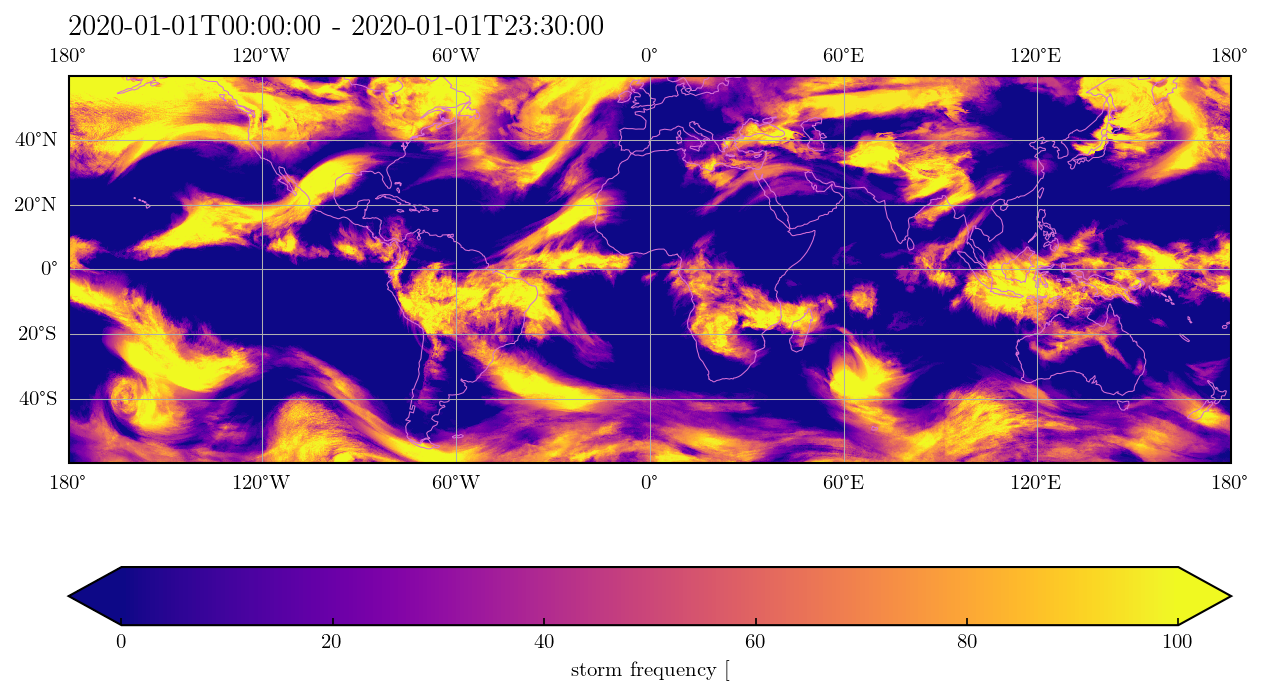

In [12]:
fig = plt.figure(figsize=(10,6))

proj = ccrs.PlateCarree()
ax = fig.add_subplot(111, projection=proj)

freq = ax.pcolormesh(ds.longitude, ds.latitude, storm_frequency , cmap = 'plasma')
ax.set_title( ( str(tiwp.time.values[0])[:-10] + ' - ' + str(tiwp.time.values[-1])[:-10] ), fontsize = 14)
gl= ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.grid(False)
ax.add_feature(cfeature.COASTLINE, edgecolor = 'orchid')
gl.right_labels = False
plt.colorbar(freq, label = r'storm frequency [%]', orientation = 'horizontal', extend = 'both') 
plt.show()

### Storm centers and tracks over South America 

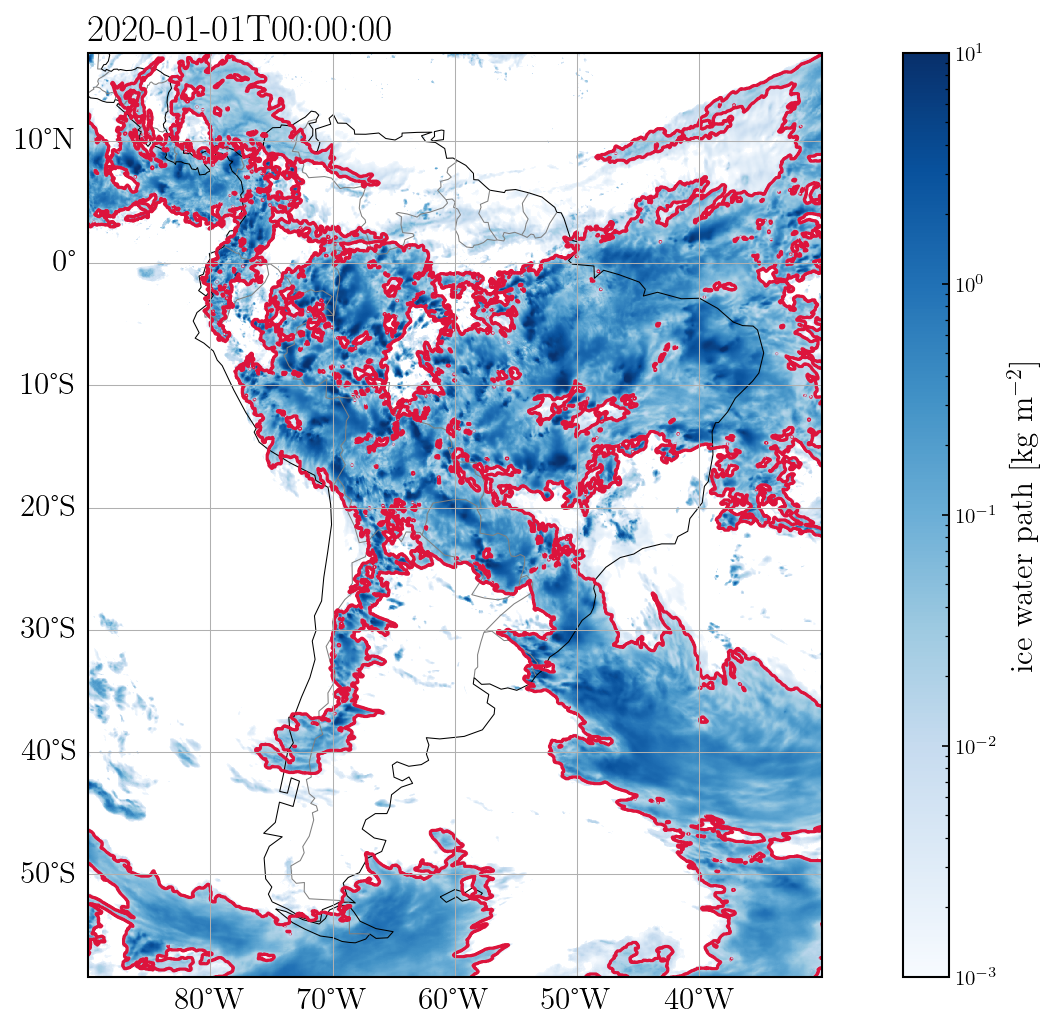

In [13]:
plt.figure(figsize= (14,8 ))

tt = 0
timestr = str(tiwp.time[tt].values)[:-10]
fs = 18 
# select all tracks that occur in specified time step 
tracks_tt = tracks[tracks.time == mask.time.values[tt]]

ax = plt.subplot(1, 1, 1 ,projection=ccrs.PlateCarree())
ax.set_extent( [-90, -30, 15, -55] )

ax.set_title(timestr, fontsize = fs)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, edgecolor = 'gray')

m= ax.pcolormesh(ds.longitude, ds.latitude, tiwp[tt], cmap = 'Blues', norm = LogNorm(1e-3,1e1))
# mask storm objects in time step 
ax.contour(mask.longitude, mask.latitude, mask[tt], levels = [1], colors = 'crimson')
gl= ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.grid(False)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}

cb=plt.colorbar(m, ax = ax )
cb.set_label( label = 'ice water path [kg m$^{-2}$]' , size = 15)

for cell in np.unique(tracks_tt.cell.values):
    track = tracks[tracks.cell == cell ]
    plt.plot(track.longitude, track.latitude, color = 'k', linewidth = 2.5)
    plt.scatter(track.longitude.values[0] , track.latitude.values[0], color = 'darkorange', s= 50.0)

plt.show()

### Storm statistics 

Histograms of the **lifetimes**, **maximum cloud areas** and **maximum ice water path intensities** of each storm:

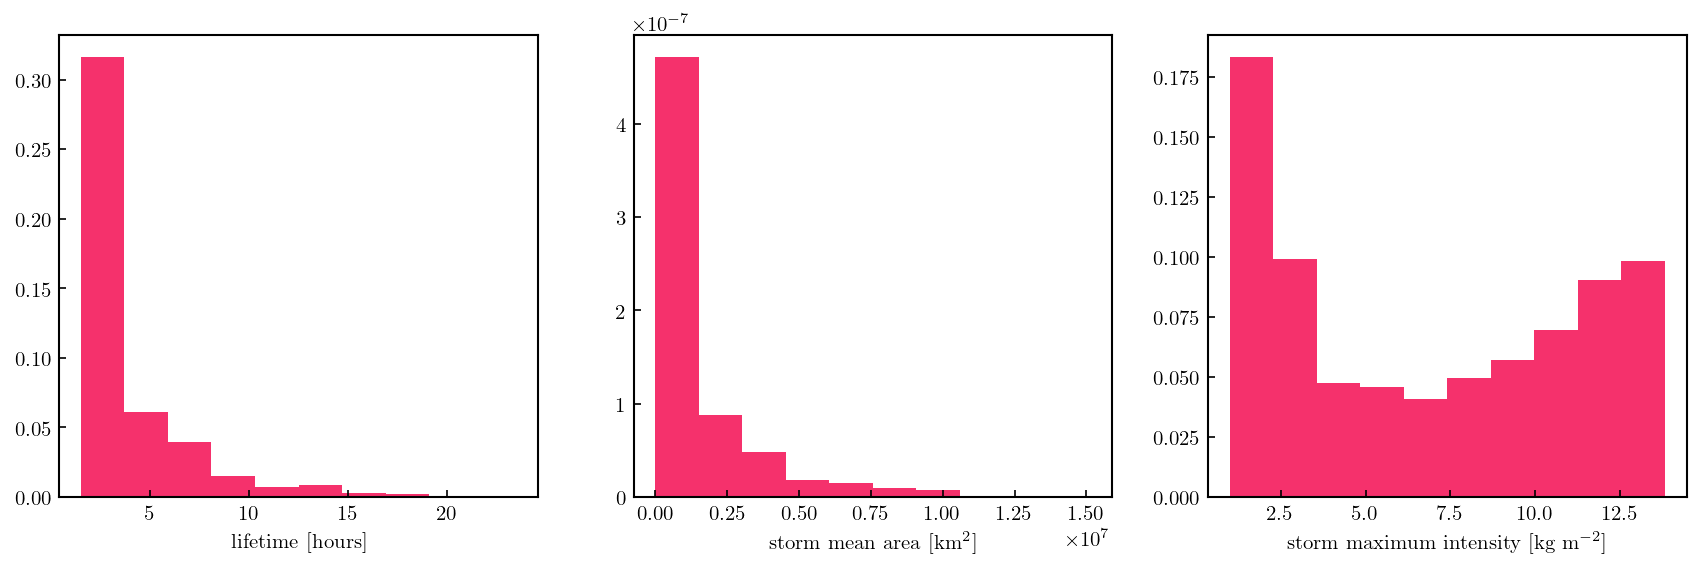

In [14]:
# get some storm statistics 
lifetimes = tracks.groupby('cell').size() * 0.5
max_areas = tracks.groupby('cell').max().ncells * 16
max_intensities = tracks.groupby('cell').max().feature_max_iwp

plt.figure(figsize=(14,4))

plt.subplot(1, 3, 1)
plt.hist(lifetimes, density = True)
plt.xlabel('lifetime [hours]')

plt.subplot(1, 3, 2)
plt.hist(max_areas, density = True)
plt.xlabel('storm mean area [km$^2$]')

plt.subplot(1, 3, 3)
plt.hist(max_intensities, density = True)
plt.xlabel('storm maximum intensity [kg m$^{-2}$]')

plt.show()